In [1]:
cd  .. 

/Users/ulukbek_attokurov/Documents/recommender/recommenders


### Import Libraries

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd 
from pathlib import Path 
from utils.readers import CSVReader
from utils.converters import format_date
from utils.splitter import train_test_split
from utils.splitter import get_sequences
from configs.split_configs import get_split_configs

### Data Preparation 

In [3]:
dirname = Path("data") 
filename = Path("events.csv") 
file_path = dirname / filename 
print(f"Path to events : {file_path}")
events = CSVReader.read(str(file_path))
events = format_date(events=events)
print(f"events: {events.shape}")

Path to events : data/events.csv
events: (2756101, 7)


### Sequence Preparation 

- generate sequences of items to create generaal embeddings based on all events: view, addtocart, transaction

In [4]:
split_point = get_split_configs()['split_point']
train_set, test_set = train_test_split(split_point=split_point, events=events)
train_sequences = get_sequences(train_set)
test_sequences = get_sequences(test_set)



### Sequence Cleaning

In [5]:
sequence_length = [len(sequence) for sequence in train_sequences]

<Axes: ylabel='Density'>

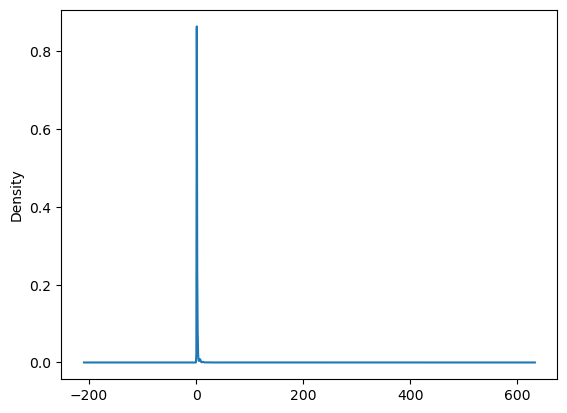

In [6]:
pd.Series(sequence_length).plot(kind = 'density')

### Majority sequences are with length 1 and there are sequences with sequences more than 100 (which is anormal for normal users)

In [7]:
sequence_length = pd.Series(sequence_length)


<Axes: >

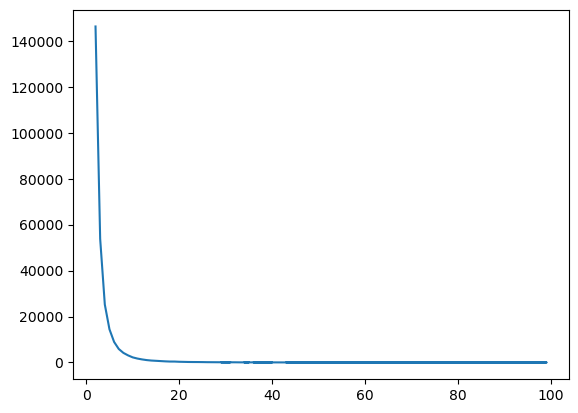

In [8]:
sequence_length[(sequence_length > 1) & (sequence_length <  100)].value_counts().plot()

We can apply the following filters to sequences: 

- sequence length is greater than 1  
- sequence length is less than 20

In [9]:
train_sequences_filtered = [seq for seq in train_sequences if len(seq) > 1 and len(seq) < 20]

In [10]:
len(train_sequences_filtered)

271654

271654 is sufficient to train word2vec only coverage can decrease!

In [11]:
from itertools import chain

initial_coverage  = len(set(list(chain(*train_sequences)))) 

filtered_coverage =  len(set(list(chain(*train_sequences_filtered)))) 

coverage  = filtered_coverage / initial_coverage  * 100


print(f"Coverage : {coverage}")

Coverage : 56.469810555413666


### Coverage can be increased in the final training when we can merge training and test sets to obtain final model for production !

### Train model 

In [12]:
from gensim.models import Word2Vec

In [13]:
model = Word2Vec()

In [15]:
model.build_vocab(train_sequences_filtered)

In [18]:
model.epochs = 10

In [26]:
params = {
    'epochs' : 10, 
    "ns_exponent" : 0.75, 
    'min_count': 1, 
    'window' : 20, 
    'vector_size' : 64
}

In [27]:
model = Word2Vec(**params)

In [28]:
model.build_vocab(train_sequences_filtered)

In [29]:
model.train(train_sequences_filtered, total_examples=model.corpus_count, epochs= model.epochs) 

(9097740, 9097740)

In [32]:
vocabulary = model.wv.index_to_key

In [35]:
embeddings = model.wv

In [36]:
embeddings.most_similar(vocabulary[0])

[(87557, 0.9895972609519958),
 (90828, 0.9889699220657349),
 (37471, 0.9884818196296692),
 (47526, 0.9872918725013733),
 (255834, 0.9863317012786865),
 (359990, 0.9856438040733337),
 (110379, 0.9852147102355957),
 (40884, 0.9851056337356567),
 (24291, 0.9845846891403198),
 (304433, 0.9845534563064575)]

In [44]:
trainer = Trainer(train_sequences_filtered, params)

In [45]:
trainer.train()

In [46]:
path_to_save = Path("model") 

filename = path_to_save / Path("embedding_model.model")

In [50]:
trainer.save(str(filename))

In [49]:
model.save("word2vec.model")

In [51]:
loaded_model = Word2Vec.load(str(filename))

In [52]:

loaded_model.wv.most_similar(vocabulary[0])

[(87557, 0.9902405142784119),
 (90828, 0.9892603158950806),
 (47526, 0.9886113405227661),
 (37471, 0.9879276752471924),
 (359990, 0.9878724217414856),
 (255834, 0.987501323223114),
 (40884, 0.9871251583099365),
 (103265, 0.986210286617279),
 (110379, 0.9859165549278259),
 (465238, 0.9850780367851257)]

In [1]:
cd ..

/Users/ulukbek_attokurov/Documents/recommender/recommenders


In [2]:
from configs.model_configs import get_model_params

In [3]:
params = get_model_params()

In [4]:
params.epochs

10

In [9]:
from typing import Dict


In [13]:
from gensim.models import Word2Vec

model = Word2Vec(**params)


In [16]:
model.ns_exponent

0.75

In [26]:
from pathlib import Path
import os 
model_path = Path("model/embedding_model.model")

loaded_model = Word2Vec.load(str(model_path))


In [46]:
import os 
from gensim.models import Word2Vec
from typing import List 
class Predictor: 
    def __init__(self, path : Path):
        self.model_path = str(path) 
        self._load_model()
        self._load_embeddings()
        self._load_vocabulary()


    def _load_model(self) -> Word2Vec: 
        self._check_path(self.model_path)
        self.model = Word2Vec.load(self.model_path) 

    def _load_embeddings(self): 
        self._check_model() 
        self.embeddings = self.model.wv

    def _load_vocabulary(self): 
        self._check_model() 
        self.vocabulary = self.model.wv.index_to_key

    def get_recommendations(self, itemid: str) -> List: 
        self._check_key(itemid) 
        recos = self.model.wv.most_similar(itemid) 
        recos = [reco[0] for reco in recos]
        return recos
    
    def get_embedding(self, itemid: str): 
        self._check_key(itemid) 
        embedding = self.embeddings[itemid]
        return embedding
    

    def _check_model(self): 
        if not self.model:
            raise ValueError("Model is not defined.")
    
    def _check_key(self, key: str): 
        self._check_model() 
        if key not in self.model.wv: 
            raise KeyError(f"Key {key} is not found.")
        
    def _check_path(self, path: str):
        if not os.path.isfile(path): 
            raise FileNotFoundError("Model is not found.") 

        

In [50]:
model_path = Path("model/embedding_model.model")
predictor = Predictor(model_path)

recommended_items = predictor.get_recommendations(vocabulary[0])

In [52]:
predictor.get_embedding("asa")

KeyError: 'Key asa is not found.'

In [28]:
vocabulary = loaded_model.wv.index_to_key